# K Strategy and Vanilla Model Comparison: Adversarial Robustness and Performance

This notebook visualizes and compares the performance of different K scheduling strategies on MNIST, including the vanilla (non-adversarial) model, using metrics such as clean accuracy, adversarial accuracy (for various k), and mean confidence.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import subprocess
import os

run_fresh_eval = True

results_path = 'results/adversarial_evaluation.csv'
if not os.path.exists(results_path) or run_fresh_eval:
    print("Running experiment script to generate results...")
    subprocess.run(['python', 'run_k_strategy_experiment.py'])
else:
    print("Results already exist. Delete the CSV if you want to rerun the experiment.")


Running experiment script to generate results...

Training with Constant scheduler...
Epoch 1/10 | Train Loss: 2.3028, Train Acc: 10.78%
Epoch 2/10 | Train Loss: 2.3014, Train Acc: 11.24% | Test Loss: 2.3010, Test Acc: 11.35%
Epoch 3/10 | Train Loss: 2.3013, Train Acc: 11.24%
Epoch 4/10 | Train Loss: 2.3013, Train Acc: 11.24% | Test Loss: 2.3010, Test Acc: 11.35%
Epoch 5/10 | Train Loss: 2.3013, Train Acc: 11.24%
Epoch 6/10 | Train Loss: 2.3013, Train Acc: 11.24% | Test Loss: 2.3010, Test Acc: 11.35%
Epoch 7/10 | Train Loss: 2.3013, Train Acc: 11.24%
Epoch 8/10 | Train Loss: 2.3013, Train Acc: 11.24% | Test Loss: 2.3011, Test Acc: 11.35%
Epoch 9/10 | Train Loss: 2.3013, Train Acc: 11.24%
Epoch 10/10 | Train Loss: 2.3013, Train Acc: 11.24% | Test Loss: 2.3010, Test Acc: 11.35%

Training with Linear scheduler...
Epoch 1/10 | Train Loss: 0.3301, Train Acc: 90.36%
Epoch 2/10 | Train Loss: 1.8161, Train Acc: 37.61% | Test Loss: 0.3238, Test Acc: 93.91%
Epoch 3/10 | Train Loss: 1.0689, Train

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import sys
sys.path.append('..')
import Models
from Attacks import pgd_attack

# Load results
df = pd.read_csv('results/adversarial_evaluation.csv')

# --- Evaluate the vanilla model ---
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# Load vanilla model
vanilla_model = Models.SmallConvNet().to(device)
vanilla_model.load_state_dict(torch.load('../models/small_conv_vanilla.pth', map_location=device))
vanilla_model.eval()
# Load MNIST test set
transform = transforms.ToTensor()
test_dataset = datasets.MNIST(root='../data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)
criterion = nn.CrossEntropyLoss()
epsilon = 0.3
k_list = [1,2,4,8,16]
# Clean accuracy
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = vanilla_model(images)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
vanilla_clean_acc = 100.0 * correct / total
# Adversarial accuracy for each k
vanilla_results = []
for k in k_list:
    correct_adv = 0
    total_adv = 0
    confidences = []
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        adv_images, _ = pgd_attack(images, labels, vanilla_model, criterion, epsilon, k, device)
        outputs = vanilla_model(adv_images)
        probs = F.softmax(outputs, dim=1)
        _, predicted = outputs.max(1)
        total_adv += labels.size(0)
        correct_adv += (predicted == labels).sum().item()
        for i in range(labels.size(0)):
            confidences.append(probs[i, predicted[i]].item())
    adv_acc = 100.0 * correct_adv / total_adv
    mean_conf = float(torch.tensor(confidences).mean()) if confidences else 0.0
    vanilla_results.append({
        'strategy': 'Vanilla',
        'k': k,
        'clean_acc': vanilla_clean_acc,
        'adv_acc': adv_acc,
        'mean_confidence': mean_conf
    })
# Add vanilla results to DataFrame
df = pd.concat([df, pd.DataFrame(vanilla_results)], ignore_index=True)
df.to_csv('results/adversarial_evaluation_with_vanilla.csv', index=False)
df.head()

,strategy,k,clean_acc,adv_acc,mean_confidence
0,Constant,1,11.35,11.35,0.112057
1,Constant,2,11.35,11.35,0.112057
2,Constant,4,11.35,11.35,0.112057
3,Constant,8,11.35,11.35,0.112057
4,Constant,16,11.35,11.35,0.112057


## 1. Clean Accuracy per Strategy

Barplot of clean accuracy for each K scheduling strategy, including vanilla.

/var/folders/k9/kd1ryl0s5dz77btv0cx404640000gn/T/ipykernel_80877/3006220193.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=clean_acc_df, x='strategy', y='clean_acc', palette='viridis')


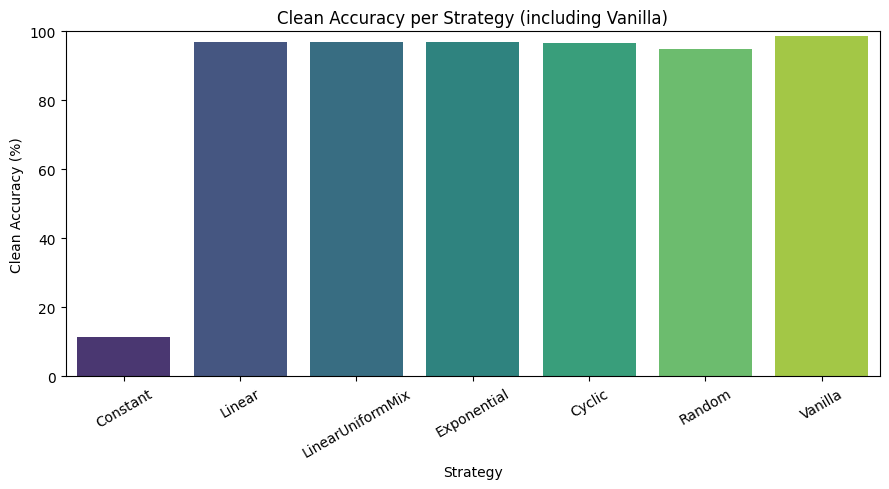

In [8]:
clean_acc_df = df.drop_duplicates(subset=['strategy'])
plt.figure(figsize=(9,5))
sns.barplot(data=clean_acc_df, x='strategy', y='clean_acc', palette='viridis')
plt.title('Clean Accuracy per Strategy (including Vanilla)')
plt.ylabel('Clean Accuracy (%)')
plt.xlabel('Strategy')
plt.ylim(0, 100)
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

## 2. Adversarial Accuracy vs. k (per Strategy)

Lineplot of adversarial accuracy as a function of attack strength (k) for each strategy, including vanilla.

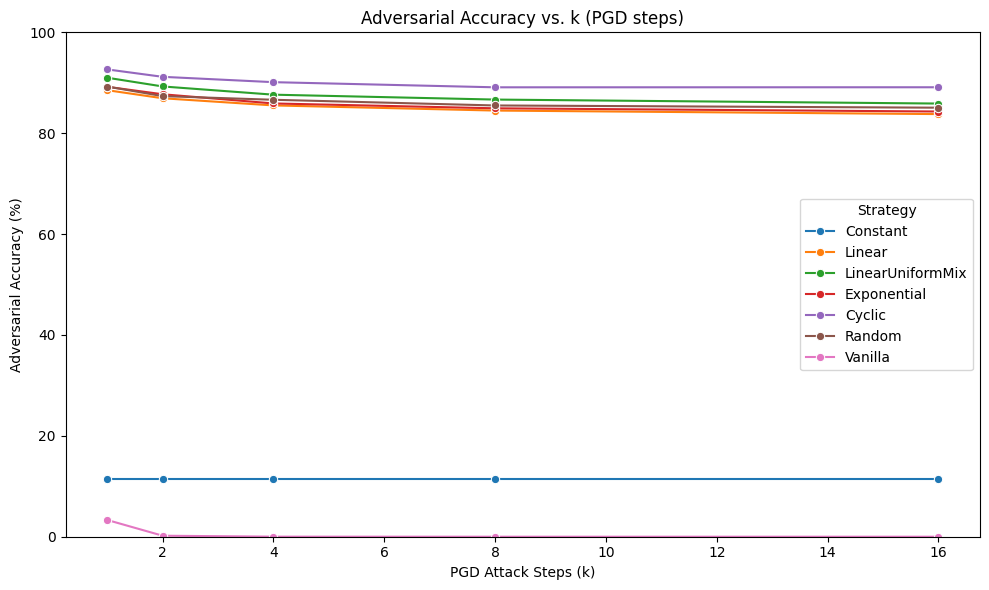

In [9]:
plt.figure(figsize=(10,6))
sns.lineplot(data=df, x='k', y='adv_acc', hue='strategy', marker='o')
plt.title('Adversarial Accuracy vs. k (PGD steps)')
plt.ylabel('Adversarial Accuracy (%)')
plt.xlabel('PGD Attack Steps (k)')
plt.ylim(0, 100)
plt.legend(title='Strategy')
plt.tight_layout()
plt.show()

## 3. Mean Confidence per Strategy and k

Boxplot of mean confidence for each strategy and attack strength, including vanilla.

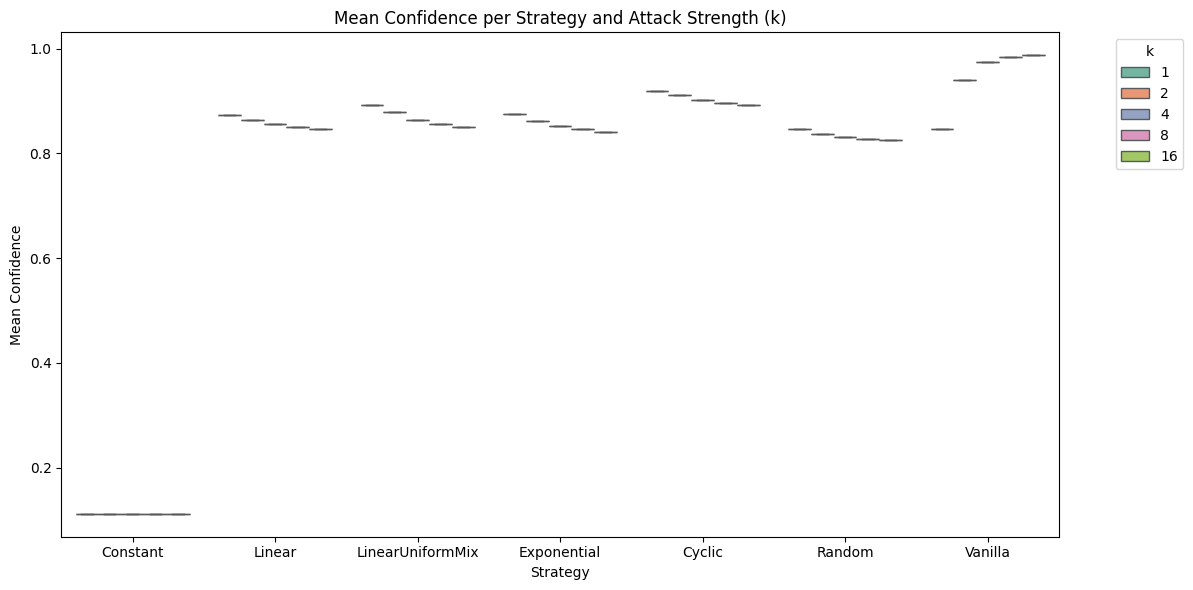

In [10]:
plt.figure(figsize=(12,6))
sns.boxplot(data=df, x='strategy', y='mean_confidence', hue='k', palette='Set2')
plt.title('Mean Confidence per Strategy and Attack Strength (k)')
plt.ylabel('Mean Confidence')
plt.xlabel('Strategy')
plt.legend(title='k', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## 4. Summary Table

Table of all metrics for each strategy and k, including vanilla.

In [11]:
df

,strategy,k,clean_acc,adv_acc,mean_confidence
0,Constant,1,11.35,11.35,0.112057
1,Constant,2,11.35,11.35,0.112057
2,Constant,4,11.35,11.35,0.112057
3,Constant,8,11.35,11.35,0.112057
4,Constant,16,11.35,11.35,0.112057
5,Linear,1,96.92,88.53,0.872992
6,Linear,2,96.92,86.93,0.863777
7,Linear,4,96.92,85.51,0.855429
8,Linear,8,96.92,84.49,0.851143
9,Linear,16,96.92,83.79,0.847314


## 5. Vanilla vs. Adversarial Strategies: Robustness and Performance

This section compares the vanilla model to adversarially trained models, highlighting the trade-off between clean accuracy and robustness.

In [13]:
# Find best strategies
best_clean = clean_acc_df.loc[clean_acc_df['clean_acc'].idxmax()]['strategy']
best_adv = df.groupby('strategy')['adv_acc'].mean().idxmax()
most_consistent = df.groupby('strategy')['adv_acc'].std().idxmin()
print(f'Best clean accuracy: {best_clean}')
print(f'Best average adversarial accuracy: {best_adv}')
print(f'Most consistent (lowest std of adv acc): {most_consistent}')

# Print a summary
for strategy in df['strategy'].unique():
    mean_adv = df[df['strategy']==strategy]['adv_acc'].mean()
    std_adv = df[df['strategy']==strategy]['adv_acc'].std()
    print(f'{strategy}: Mean adv acc = {mean_adv:.2f}%, Std = {std_adv:.2f}')

# Vanilla vs. best adversarial
vanilla_mean_adv = df[df['strategy']=='Vanilla']['adv_acc'].mean()
best_adv_mean = df[df['strategy']==best_adv]['adv_acc'].mean()
print(f'Vanilla mean adversarial accuracy: {vanilla_mean_adv:.2f}%')
print(f'Best adversarial strategy mean adversarial accuracy: {best_adv_mean:.2f}%')
#print('The vanilla model typically has higher clean accuracy but much lower adversarial robustness. Adversarially trained models trade some clean accuracy for much higher robustness to attacks.')

Best clean accuracy: Vanilla
Best average adversarial accuracy: Cyclic
Most consistent (lowest std of adv acc): Constant
Constant: Mean adv acc = 11.35%, Std = 0.00
Linear: Mean adv acc = 85.85%, Std = 1.91
LinearUniformMix: Mean adv acc = 88.09%, Std = 2.06
Exponential: Mean adv acc = 86.41%, Std = 2.02
Cyclic: Mean adv acc = 90.43%, Std = 1.51
Random: Mean adv acc = 86.76%, Std = 1.66
Vanilla: Mean adv acc = 0.71%, Std = 1.46
Vanilla mean adversarial accuracy: 0.71%
Best adversarial strategy mean adversarial accuracy: 90.43%
